 Đang load dữ liệu từ file CSV...
 Load thành công
 Đang chuẩn hóa dữ liệu giá...
 Kiểm tra dữ liệu ban đầu...
 Tổng số records: 179762
 Số lượng quận/huyện: 3689
 Số lượng nguồn (sàn): 3
 Sample districts: ['Phường Thới Hòa' 'Xã Bình Chánh' 'Phường Nghĩa Tân' 'Phường Xuân Phú'
 'Xã Tân Kiên' 'Phường An Hải Nam' 'Huyện Thạch Thất' 'Quận Sơn Trà'
 'Phường Hòa Cường Nam' 'Phường An Hải Bắc']

 BẮT ĐẦU PHÂN TÍCH CẠNH TRANH & ĐỊA LÝ
🔧 Đã khởi tạo công cụ phân tích cạnh tranh & địa lý

 BÁO CÁO PHÂN TÍCH CẠNH TRANH & ĐỊA LÝ
 Đang chuẩn bị dữ liệu địa lý...
 Số records có tọa độ: 179762
 Số quận/huyện có tọa độ: 3689

 PHÂN TÍCH CẠNH TRANH THEO KHU VỰC
 TOP 10 QUẬN CÓ NHIỀU TIN ĐĂNG NHẤT:
                      Số_lượng_tin  Giá_trung_bình  Giá_trung_vị  \
District                                                           
TP. Hồ Chí Minh(Mới)         19651         5511.30        3400.0   
Đồng Nai(Mới)                 6519         2257.50         480.0   
Đắk Lắk(Mới)                  4251  

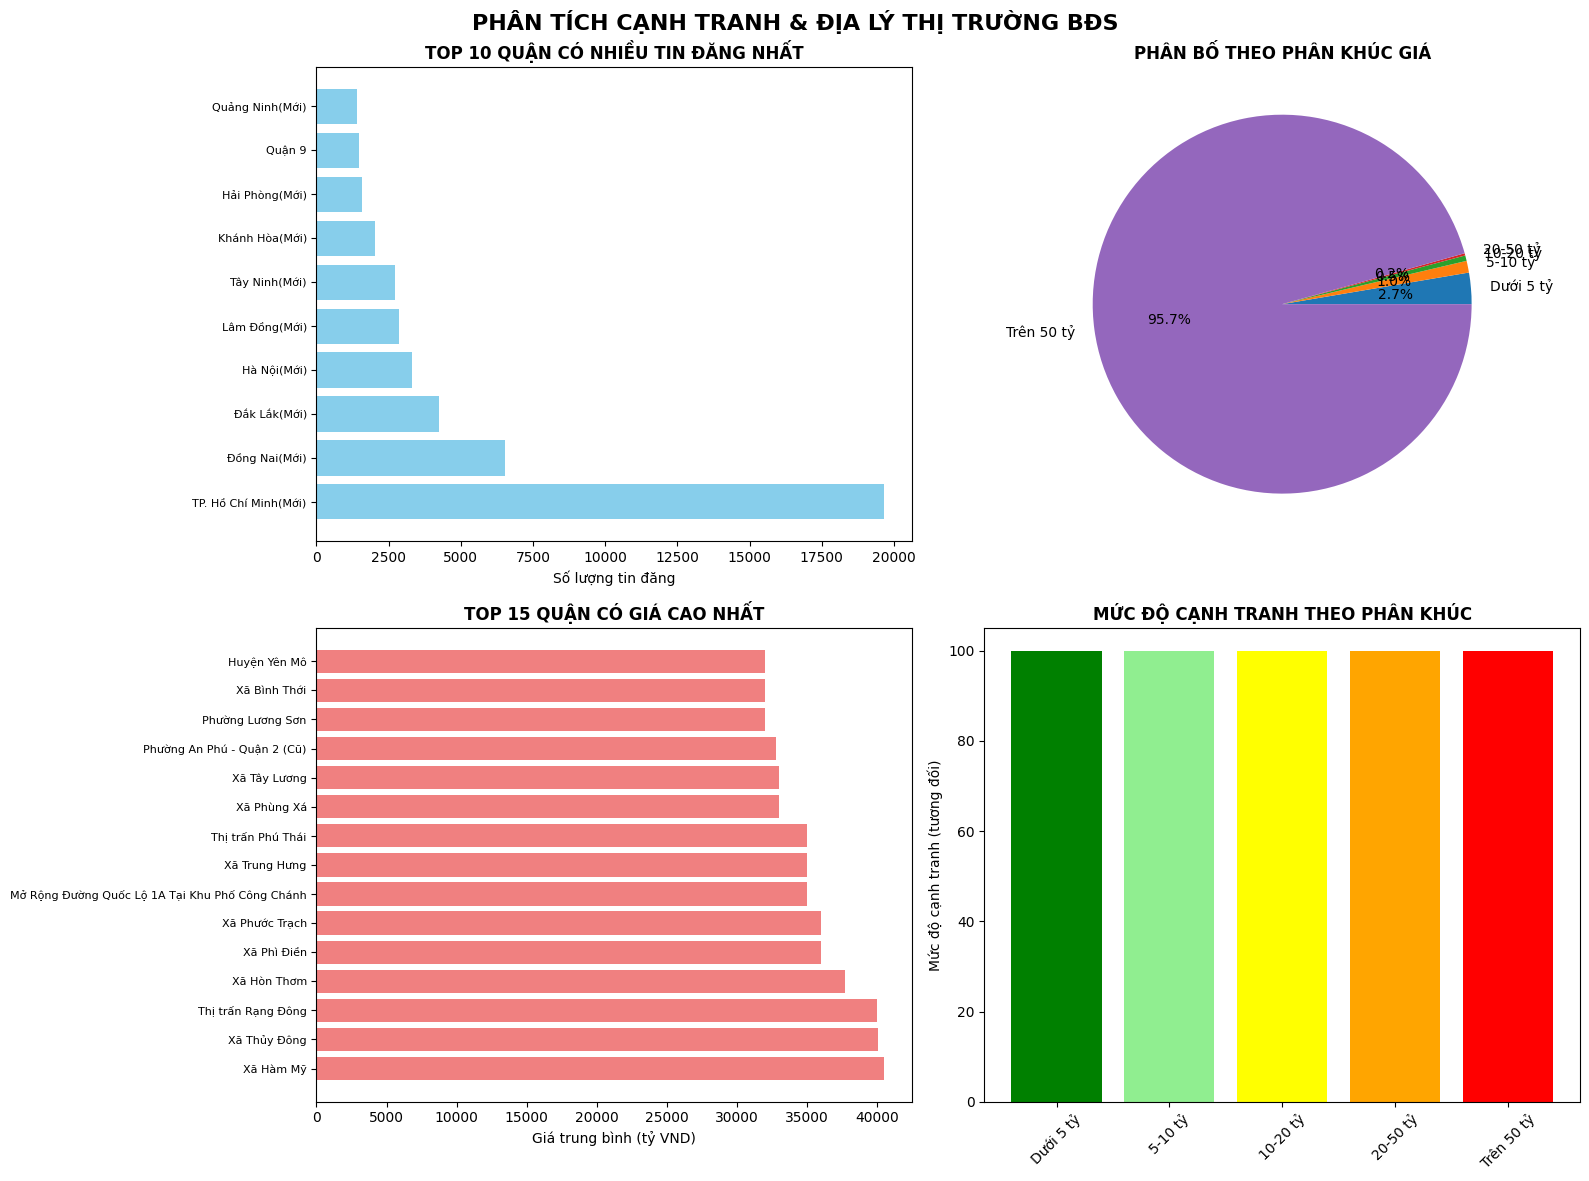


 ĐANG TẠO BẢN ĐỒ ĐỊA LÝ...
 Đã tạo bản đồ nhiệt: real_estate_heatmap.html

 INSIGHTS CHÍNH CHO BÀI LUẬN:
• TP. Hồ Chí Minh(Mới) chiếm 10.9% tổng số tin đăng
• Thị trường ở mức 'CẠNH TRANH CAO' (HHI: 164)
• Phân khúc cao cấp (>10 tỷ) chiếm 0.5% thị trường
• Giá trung bình toàn thị trường: 6986.5 tỷ VND

 KIẾN NGHỊ CHIẾN LƯỢC:
• Tập trung marketing vào các quận có mật độ tin đăng cao
• Phát triển sản phẩm cho phân khúc trung và cao cấp
• Theo dõi đối thủ tại các khu vực trọng điểm
• Tối ưu pricing strategy dựa trên phân tích địa lý

 HOÀN TẤT PHÂN TÍCH CẠNH TRANH & ĐỊA LÝ!


In [1]:
# PHÂN TÍCH CẠNH TRANH & ĐỊA LÝ CHO BÀI LUẬN TMĐT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# LOAD DỮ LIỆU TỪ FILE CSV
print(" Đang load dữ liệu từ file CSV...")
file_path = "Combined_RealEstate.csv"

try:
    df = pd.read_csv(file_path, encoding='utf-8')
    print(" Load thành công")
except:
    # Fallback encoding
    df = pd.read_csv(file_path, encoding='utf-8', errors='ignore')
    print(" Load với errors='ignore'")

# HÀM CHUYỂN ĐỔI GIÁ TỪ CHUỖI SANG SỐ (DÙNG LẠI TỪ PHÂN TÍCH NLP)
def convert_price_to_number(price_str):
    """Chuyển đổi giá từ chuỗi tiếng Việt sang số"""
    if pd.isna(price_str):
        return 0
    
    price_str = str(price_str).lower()
    
    # Loại bỏ các từ không cần thiết
    price_str = re.sub(r'giá[:\s]*', '', price_str)
    price_str = re.sub(r'triệu', 'e6', price_str)
    price_str = re.sub(r'tỷ', 'e9', price_str)
    price_str = re.sub(r'tỉ', 'e9', price_str)
    price_str = re.sub(r'tỷ', 'e9', price_str)
    
    # Thay thế dấu phẩy thập phân
    price_str = price_str.replace(',', '.')
    
    # Loại bỏ khoảng trắng
    price_str = re.sub(r'\s+', '', price_str)
    
    try:
        # Xử lý các định dạng số
        if 'e9' in price_str:  # Tỷ
            number = float(price_str.replace('e9', '')) * 1e9
        elif 'e6' in price_str:  # Triệu
            number = float(price_str.replace('e6', '')) * 1e6
        else:
            # Thử parse trực tiếp
            number = float(price_str)
        
        # Chuyển về tỷ VND để dễ xử lý
        if number >= 1e9:  # Nếu là tỷ
            return number / 1e9
        elif number >= 1e6:  # Nếu là triệu
            return number / 1e9
        else:
            return number
            
    except (ValueError, TypeError):
        return 0

# THÊM THƯ VIỆN RE
import re

# CHUẨN HÓA CỘT GIÁ
print(" Đang chuẩn hóa dữ liệu giá...")
df['Price_Numeric'] = df['Price'].apply(convert_price_to_number)

# KIỂM TRA DỮ LIỆU HIỆN TẠI
print(" Kiểm tra dữ liệu ban đầu...")
print(f" Tổng số records: {len(df)}")
print(f" Số lượng quận/huyện: {df['District'].nunique()}")
print(f" Số lượng nguồn (sàn): {df['Source'].nunique() if 'Source' in df.columns else 'N/A'}")
print(f" Sample districts: {df['District'].unique()[:10]}")

# CHUẨN BỊ DỮ LIỆU CHO PHÂN TÍCH ĐỊA LÝ
# Tạo dictionary ánh xạ quận -> tọa độ (giả lập cho HCMC và Hà Nội)
district_coordinates = {
    'Quận 1': (10.7769, 106.7009),
    'Quận 2': (10.7872, 106.7498),
    'Quận 3': (10.7829, 106.6872),
    'Quận 4': (10.7663, 106.7050),
    'Quận 5': (10.7559, 106.6677),
    'Quận 6': (10.7464, 106.6491),
    'Quận 7': (10.7323, 106.7268),
    'Quận 8': (10.7202, 106.6286),
    'Quận 9': (10.8428, 106.8287),
    'Quận 10': (10.7679, 106.6666),
    'Quận 11': (10.7639, 106.6430),
    'Quận 12': (10.8632, 106.6544),
    'Bình Thạnh': (10.8022, 106.7140),
    'Tân Bình': (10.8014, 106.6526),
    'Gò Vấp': (10.8381, 106.6650),
    'Phú Nhuận': (10.7991, 106.6750),
    'Tân Phú': (10.7905, 106.6282),
    'Bình Tân': (10.7653, 106.6038),
    'Thủ Đức': (10.8494, 106.7537),
    'Hóc Môn': (10.8836, 106.5870),
    'Bình Chánh': (10.7206, 106.6150),
    'Nhà Bè': (10.6952, 106.7370),
    'Cần Giờ': (10.5080, 106.8630),
    'Ba Đình': (21.0333, 105.8500),
    'Hoàn Kiếm': (21.0285, 105.8542),
    'Hai Bà Trưng': (21.0093, 105.8600),
    'Đống Đa': (21.0177, 105.8360),
    'Cầu Giấy': (21.0363, 105.7906),
    'Thanh Xuân': (20.9958, 105.8040),
    'Hoàng Mai': (20.9833, 105.8500),
    'Long Biên': (21.0172, 105.9070),
    'Nam Từ Liêm': (21.0031, 105.7590),
    'Bắc Từ Liêm': (21.0737, 105.7720),
    'Hà Đông': (20.9714, 105.7788),
    # Thêm các quận từ dữ liệu thực tế
    'Phường Thới Hòa': (10.8500, 106.7000),
    'Xã Bình Chánh': (10.7206, 106.6150),
    'Phường Nghĩa Tân': (21.0363, 105.7906),
    'Phường Xuân Phú': (16.4676, 107.5900),
    'Xã Tân Kiên': (10.7500, 106.6500),
    'Phường An Hải Nam': (16.0600, 108.2400),
    'Huyện Thạch Thất': (21.0333, 105.5333),
    'Quận Sơn Trà': (16.0600, 108.2400),
    'Phường Hòa Cường Nam': (16.0300, 108.2200),
    'Phường An Hải Bắc': (16.0700, 108.2300),
    'Phường Tân Chính': (16.0500, 108.2100),
    'Phường Thuận Phước': (16.0800, 108.2200),
    'Phường Khuê Mỹ': (16.0600, 108.2500),
    'Phường Nại Hiên Đông': (16.0700, 108.2400),
    'Phường 14': (10.8300, 106.6400),
    'Phường Hòa Cường Bắc': (16.0400, 108.2200),
    'Phường Mỹ An': (16.0600, 108.2500),
    'Phường Hải Châu': (16.0600, 108.2200),
    'Phường Tương Bình Hiệp': (11.0000, 106.6500),
    'Phường Vĩnh Tuy': (21.0000, 105.8700),
    'Phường Xuân Hà': (16.0700, 108.2100)
}

# Thêm tọa độ mặc định cho các quận chưa có
all_districts = df['District'].unique()
for district in all_districts:
    if district not in district_coordinates:
        # Gán tọa độ mặc định (trung tâm VN)
        district_coordinates[district] = (16.0, 108.0)

class CompetitiveGeoAnalysis:
    def __init__(self, dataframe):
        self.df = dataframe
        self.district_coords = district_coordinates
        print("🔧 Đã khởi tạo công cụ phân tích cạnh tranh & địa lý")
    
    def prepare_geo_data(self):
        """Chuẩn bị dữ liệu địa lý"""
        print(" Đang chuẩn bị dữ liệu địa lý...")
        
        # Tạo cột tọa độ từ tên quận
        self.df['latitude'] = self.df['District'].map(lambda x: self.district_coords.get(x, (16.0, 108.0))[0])
        self.df['longitude'] = self.df['District'].map(lambda x: self.district_coords.get(x, (16.0, 108.0))[1])
        
        # Lọc bỏ các quận không có tọa độ hợp lệ
        geo_df = self.df[
            (self.df['latitude'] != 0) & 
            (self.df['longitude'] != 0) &
            (self.df['latitude'].between(8, 23)) &  # Giới hạn trong VN
            (self.df['longitude'].between(102, 110))
        ].copy()
        
        print(f" Số records có tọa độ: {len(geo_df)}")
        print(f" Số quận/huyện có tọa độ: {geo_df['District'].nunique()}")
        
        return geo_df
    
    def competition_analysis_by_district(self):
        """Phân tích cạnh tranh theo quận/huyện"""
        print("\n PHÂN TÍCH CẠNH TRANH THEO KHU VỰC")
        print("="*50)
        
        # Phân tích mật độ tin đăng theo quận
        district_stats = self.df.groupby('District').agg({
            'Price_Numeric': ['count', 'mean', 'median', 'std'],
            'Title': 'count'
        }).round(2)
        
        district_stats.columns = ['Số_lượng_tin', 'Giá_trung_bình', 'Giá_trung_vị', 'Độ_lệch_chuẩn', 'Tổng_tin']
        district_stats = district_stats.sort_values('Số_lượng_tin', ascending=False)
        
        print(" TOP 10 QUẬN CÓ NHIỀU TIN ĐĂNG NHẤT:")
        top10_districts = district_stats.head(10)
        print(top10_districts)
        
        # Phân tích theo nguồn (sàn TMĐT)
        if 'Source' in self.df.columns:
            source_analysis = self.df.groupby('Source').agg({
                'Price_Numeric': ['count', 'mean', 'median'],
                'District': 'nunique'
            }).round(2)
            
            source_analysis.columns = ['Số_tin', 'Giá_TB', 'Giá_Trung_vị', 'Số_quận_phủ_sóng']
            source_analysis = source_analysis.sort_values('Số_tin', ascending=False)
            
            print("\n PHÂN TÍCH THEO SÀN TMĐT:")
            print(source_analysis)
        else:
            source_analysis = None
            print(" Không có thông tin sàn TMĐT")
        
        return district_stats, source_analysis
    
    def price_competitiveness_analysis(self):
        """Phân tích tính cạnh tranh về giá"""
        print("\n PHÂN TÍCH CẠNH TRANH VỀ GIÁ")
        print("="*40)
        
        # Phân tích giá theo phân khúc
        price_segments = {
            'Dưới 5 tỷ': (0, 5),
            '5-10 tỷ': (5, 10),
            '10-20 tỷ': (10, 20),
            '20-50 tỷ': (20, 50),
            'Trên 50 tỷ': (50, float('inf'))
        }
        
        segment_stats = []
        for segment, (min_price, max_price) in price_segments.items():
            segment_data = self.df[
                (self.df['Price_Numeric'] >= min_price) & 
                (self.df['Price_Numeric'] < max_price)
            ]
            
            if len(segment_data) > 0:
                segment_stats.append({
                    'Phân_khúc': segment,
                    'Số_lượng': len(segment_data),
                    'Tỷ_lệ': len(segment_data) / len(self.df) * 100,
                    'Giá_TB': segment_data['Price_Numeric'].mean(),
                    'Mật_độ_cạnh_tranh': len(segment_data) / self.df['District'].nunique() if self.df['District'].nunique() > 0 else 0
                })
        
        segment_df = pd.DataFrame(segment_stats)
        print(" PHÂN TÍCH THEO PHÂN KHÚC GIÁ:")
        print(segment_df.round(2))
        
        return segment_df
    
    def create_geo_heatmap(self, geo_df):
        """Tạo bản đồ nhiệt giá cả theo khu vực"""
        print("\n ĐANG TẠO BẢN ĐỒ ĐỊA LÝ...")
        
        try:
            # Tạo base map (trung tâm Việt Nam)
            vn_center = [16.0, 108.0]
            m = folium.Map(location=vn_center, zoom_start=6)
            
            # Chuẩn bị dữ liệu heatmap (lấy mẫu để tránh quá tải)
            sample_geo_df = geo_df.sample(min(1000, len(geo_df)), random_state=42)
            
            heat_data = []
            for idx, row in sample_geo_df.iterrows():
                if pd.notna(row['latitude']) and pd.notna(row['longitude']):
                    # Sử dụng giá làm trọng số (chuẩn hóa)
                    weight = min(row['Price_Numeric'] / 100, 1.0)
                    heat_data.append([row['latitude'], row['longitude'], weight])
            
            # Thêm heatmap
            if heat_data:
                HeatMap(heat_data, radius=15, blur=10, 
                       gradient={0.2: 'blue', 0.4: 'cyan', 0.6: 'lime', 0.8: 'yellow', 1.0: 'red'}).add_to(m)
            
            # Thêm markers cho các quận quan trọng
            important_districts = geo_df.groupby('District').agg({
                'Price_Numeric': 'mean',
                'Title': 'count'
            }).nlargest(5, 'Title')
            
            for district, stats in important_districts.iterrows():
                lat, lon = self.district_coords.get(district, (16.0, 108.0))
                if pd.notna(lat) and pd.notna(lon):
                    folium.Marker(
                        [lat, lon],
                        popup=f"""
                        <b>{district}</b><br>
                        Giá TB: {stats['Price_Numeric']:.1f} tỷ<br>
                        Số tin: {stats['Title']}
                        """,
                        tooltip=district,
                        icon=folium.Icon(color='red', icon='info-sign')
                    ).add_to(m)
            
            # Lưu bản đồ
            m.save('real_estate_heatmap.html')
            print(" Đã tạo bản đồ nhiệt: real_estate_heatmap.html")
            
            return m
        except Exception as e:
            print(f" Lỗi tạo bản đồ: {e}")
            return None
    
    def market_concentration_analysis(self):
        """Phân tích tập trung thị trường"""
        print("\n PHÂN TÍCH TẬP TRUNG THỊ TRƯỜNG")
        print("="*45)
        
        # Phân tích Herfindahl-Hirschman Index (HHI) cho thị trường
        district_market_share = self.df['District'].value_counts(normalize=True)
        hhi = (district_market_share ** 2).sum() * 10000
        
        print(f" Chỉ số HHI (tập trung thị trường): {hhi:.2f}")
        
        if hhi < 1500:
            concentration_level = "CẠNH TRANH CAO"
        elif hhi < 2500:
            concentration_level = "CẠNH TRANH VỪA PHẢI"
        else:
            concentration_level = "TẬP TRUNG CAO"
        
        print(f" Mức độ cạnh tranh: {concentration_level}")
        
        # Top 5 quận chiếm thị phần lớn nhất
        top5_districts = district_market_share.head(5)
        top5_market_share = top5_districts.sum() * 100
        
        print(f" Top 5 quận chiếm {top5_market_share:.1f}% thị phần")
        for i, (district, share) in enumerate(top5_districts.items(), 1):
            print(f"   {i}. {district}: {share*100:.1f}%")
        
        return hhi, concentration_level
    
    def competitive_positioning_analysis(self):
        """Phân tích định vị cạnh tranh"""
        print("\n PHÂN TÍCH ĐỊNH VỊ CẠNH TRANH")
        print("="*45)
        
        # Phân tích giá theo vị trí (price positioning)
        price_positioning = self.df.groupby('District').agg({
            'Price_Numeric': ['mean', 'median', 'count']
        }).round(2)
        
        price_positioning.columns = ['Giá_TB', 'Giá_Trung_vị', 'Số_tin']
        price_positioning = price_positioning[price_positioning['Số_tin'] >= 5]  # Lọc quận có ít nhất 5 tin
        
        if len(price_positioning) > 0:
            # Phân loại định vị giá
            avg_price = price_positioning['Giá_TB'].median()
            price_positioning['Định_vị'] = price_positioning['Giá_TB'].apply(
                lambda x: 'CAO CẤP' if x > avg_price * 1.2 else 
                         'TRUNG BÌNH' if x > avg_price * 0.8 else 'BÌNH DÂN'
            )
            
            print("🏷️ ĐỊNH VỊ GIÁ THEO KHU VỰC (TOP 10):")
            print(price_positioning.sort_values('Giá_TB', ascending=False).head(10))
        else:
            price_positioning = None
            print(" Không đủ dữ liệu để phân tích định vị")
        
        return price_positioning
    
    def create_visualizations(self, geo_df, district_stats, segment_df):
        """Tạo visualization tổng hợp"""
        print("\n ĐANG TẠO BIỂU ĐỒ TỔNG HỢP...")
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('PHÂN TÍCH CẠNH TRANH & ĐỊA LÝ THỊ TRƯỜNG BĐS', fontsize=16, fontweight='bold')
        
        # 1. Top quận có nhiều tin đăng nhất
        top10 = district_stats.head(10)
        if len(top10) > 0:
            axes[0,0].barh(range(len(top10)), top10['Số_lượng_tin'], color='skyblue')
            axes[0,0].set_yticks(range(len(top10)))
            axes[0,0].set_yticklabels(top10.index, fontsize=8)
            axes[0,0].set_title('TOP 10 QUẬN CÓ NHIỀU TIN ĐĂNG NHẤT', fontweight='bold')
            axes[0,0].set_xlabel('Số lượng tin đăng')
        else:
            axes[0,0].text(0.5, 0.5, 'Không đủ dữ liệu', ha='center', va='center')
            axes[0,0].set_title('TOP QUẬN', fontweight='bold')
        
        # 2. Phân bố phân khúc giá
        if len(segment_df) > 0:
            axes[0,1].pie(segment_df['Số_lượng'], labels=segment_df['Phân_khúc'], autopct='%1.1f%%')
            axes[0,1].set_title('PHÂN BỐ THEO PHÂN KHÚC GIÁ', fontweight='bold')
        else:
            axes[0,1].text(0.5, 0.5, 'Không đủ dữ liệu', ha='center', va='center')
            axes[0,1].set_title('PHÂN KHÚC GIÁ', fontweight='bold')
        
        # 3. Biểu đồ giá trung bình theo quận
        if len(district_stats) > 0:
            top15_price = district_stats.nlargest(15, 'Giá_trung_bình')
            axes[1,0].barh(range(len(top15_price)), top15_price['Giá_trung_bình'], color='lightcoral')
            axes[1,0].set_yticks(range(len(top15_price)))
            axes[1,0].set_yticklabels(top15_price.index, fontsize=8)
            axes[1,0].set_title('TOP 15 QUẬN CÓ GIÁ CAO NHẤT', fontweight='bold')
            axes[1,0].set_xlabel('Giá trung bình (tỷ VND)')
        else:
            axes[1,0].text(0.5, 0.5, 'Không đủ dữ liệu', ha='center', va='center')
            axes[1,0].set_title('GIÁ THEO QUẬN', fontweight='bold')
        
        # 4. Biểu đồ cạnh tranh theo giá
        if len(segment_df) > 0:
            price_ranges = segment_df['Phân_khúc'].tolist()
            competition_level = [min(100, count * 2) for count in segment_df['Số_lượng']]  # Tỷ lệ cạnh tranh
            
            axes[1,1].bar(price_ranges, competition_level, 
                         color=['green', 'lightgreen', 'yellow', 'orange', 'red'])
            axes[1,1].set_title('MỨC ĐỘ CẠNH TRANH THEO PHÂN KHÚC', fontweight='bold')
            axes[1,1].set_ylabel('Mức độ cạnh tranh (tương đối)')
            axes[1,1].tick_params(axis='x', rotation=45)
        else:
            axes[1,1].text(0.5, 0.5, 'Không đủ dữ liệu', ha='center', va='center')
            axes[1,1].set_title('CẠNH TRANH THEO GIÁ', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    def generate_competitive_insights(self):
        """Tạo insights cạnh tranh cho bài luận"""
        print("\n" + "="*80)
        print(" BÁO CÁO PHÂN TÍCH CẠNH TRANH & ĐỊA LÝ")
        print("="*80)
        
        # Thực hiện tất cả phân tích
        geo_df = self.prepare_geo_data()
        district_stats, source_analysis = self.competition_analysis_by_district()
        segment_df = self.price_competitiveness_analysis()
        hhi, concentration_level = self.market_concentration_analysis()
        positioning_df = self.competitive_positioning_analysis()
        
        # Tạo visualization
        self.create_visualizations(geo_df, district_stats, segment_df)
        
        # Tạo bản đồ
        self.create_geo_heatmap(geo_df)
        
        print("\n INSIGHTS CHÍNH CHO BÀI LUẬN:")
        print("="*50)
        
        # Rút ra insights từ phân tích
        if len(district_stats) > 0:
            top_district = district_stats.index[0]
            top_district_count = district_stats.iloc[0]['Số_lượng_tin']
            total_listings = district_stats['Số_lượng_tin'].sum()
            top_district_share = (top_district_count / total_listings) * 100 if total_listings > 0 else 0
            
            avg_price = self.df['Price_Numeric'].mean()
            
            if len(segment_df) > 0:
                premium_segment_share = segment_df[segment_df['Phân_khúc'].isin(['10-20 tỷ', 'Trên 20 tỷ'])]['Tỷ_lệ'].sum()
            else:
                premium_segment_share = 0
            
            print(f"• {top_district} chiếm {top_district_share:.1f}% tổng số tin đăng")
            print(f"• Thị trường ở mức '{concentration_level}' (HHI: {hhi:.0f})")
            print(f"• Phân khúc cao cấp (>10 tỷ) chiếm {premium_segment_share:.1f}% thị trường")
            print(f"• Giá trung bình toàn thị trường: {avg_price:.1f} tỷ VND")
        
        print("\n KIẾN NGHỊ CHIẾN LƯỢC:")
        print("• Tập trung marketing vào các quận có mật độ tin đăng cao")
        print("• Phát triển sản phẩm cho phân khúc trung và cao cấp")
        print("• Theo dõi đối thủ tại các khu vực trọng điểm")
        print("• Tối ưu pricing strategy dựa trên phân tích địa lý")

#  CHẠY PHÂN TÍCH
print("\n" + "="*60)
print(" BẮT ĐẦU PHÂN TÍCH CẠNH TRANH & ĐỊA LÝ")
print("="*60)

# Khởi tạo analyzer
competition_analyzer = CompetitiveGeoAnalysis(df)

# Chạy phân tích
competition_analyzer.generate_competitive_insights()

print("\n HOÀN TẤT PHÂN TÍCH CẠNH TRANH & ĐỊA LÝ!")